In [351]:
#pip install pgeocode

In [1]:
import pgeocode

In [325]:
import pandas as pd
import numpy as np
import requests
import json
import datetime
import random
import timeit
import time
import matplotlib.pyplot as plt
%matplotlib inline

In [396]:
plt.rcParams["figure.figsize"] = (5,6)

In [355]:
### Import Georgia Boundaries
ga = pd.read_csv(r'\\CPFSPRDAPAWSE01\userdata$\shilts\Documents\Personal\ga.csv', header=None)
ga.head(2)

,0,1
0,33.90172,-85.38658
1,34.00010,-85.40592


### Import addresses

In [4]:
# df = pd.read_csv(r'\\CPFSPRDAPAWSE01\userdata$\shilts\Documents\Personal\Council Addresses.csv')
# df['Zip5'] = df['Zip'].apply(lambda x: str(x)[:5])
# df.tail()

### Zips to Lat_Lon

In [4]:
def lat_lon(zip5):
    lat_lon = nomi.query_postal_code(zip5)
    return lat_lon['latitude'],lat_lon['longitude']


In [ ]:
# nomi = pgeocode.Nominatim('us')
# df['lat_lon'] = df['Zip5'].apply(lambda x: lat_lon(x))
# df.to_csv(r'\\CPFSPRDAPAWSE01\userdata$\shilts\Documents\Personal\Council Addresses w Lat.csv')

### Define distance calculation

In [3]:
df = pd.read_csv(r'\\CPFSPRDAPAWSE01\userdata$\shilts\Documents\Personal\Council Addresses w Lat.csv')
df['lat'] = df['lat_lon'].apply(lambda x: float(x[1:-1].split(',')[0]))
df['lon'] = df['lat_lon'].apply(lambda x: float(x[1:-1].split(',')[1]))

df.head()

,Unnamed: 0,lngCouncil,calCouncil,Address,City,State,Zip,Zip5,lat_lon,lat,lon
0,0,15996,St. John Paul II Council 15996,6301 Cedarcrest Road,Acworth,GA,30101,30101,"(34.0756, -84.6477)",34.0756,-84.6477
1,1,3607,Msgr. Daniel J. Bourke Council 3607,421 Edgewood Lane,Albany,GA,31707-3909,31707,"(31.5789, -84.2118)",31.5789,-84.2118
2,2,6532,St. Thomas Aquinas Council 6532,535 Rucker Road,Alpharetta,GA,30004-4048,30004,"(34.1124, -84.302)",34.1124,-84.3020
3,3,7113,Americus Council 7113,332 South Lee Street,Americus,GA,31709-3916,31709,"(32.0404, -84.2153)",32.0404,-84.2153
4,4,6514,Deacon William P. Lakin Council 6514,958 Epps Bridge Parkway,Athens,GA,30606,30606,"(33.9461, -83.41799999999998)",33.9461,-83.4180


In [5]:
def get_distance(a,b):
    r = requests.get(f"http://router.project-osrm.org/route/v1/car/{a[1]},{a[0]};{b[1]},{b[0]}?overview=false""")
    routes = json.loads(r.content)
    route_1 = routes.get("routes")[0]
    return route_1["duration"]/3600

In [6]:
def get_distance(lat1, lon1, lat2, lon2):
    r = requests.get(f"http://router.project-osrm.org/route/v1/car/{lon1},{lat1};{lon2},{lat2}?overview=false""")
    routes = json.loads(r.content)
    route_1 = routes.get("routes")[0]
    return route_1["duration"]/3600

Test if the get_distance works! 

In [208]:
lat1 = df['lat'][0]
lon1 = df['lon'][0]
lat2 = df['lat'][2]
lon2 = df['lon'][2]

get_distance(lat1, lon1, lat2, lon2)

0.753361111111111

### Create pairs of Lat/Lon to test

First, test on small set. Start with group of 5. 

In [215]:
test_list = []
items = 114

for x in range(items):
    for y in range(x+1,items):
        test_list.append([x,y])
print(len(test_list))

6441


In [212]:
def get_distance_mock(lat1, lon1, lat2, lon2):
    return random.randint(1,5)*(np.abs(lat1-lat2)+np.abs(lon1-lon2))

### This section uses a sleep to avoid overloading the API. WIll take a while to run!

First cell is commented out; this is only needed when running for the first time. Otherwise, call in csv

In [225]:
# dist_list = []
# counter = 0
# for item in test_list:
#     counter += 1
#     lat1 = df['lat'][item[0]]
#     lon1 = df['lon'][item[0]]
#     lat2 = df['lat'][item[1]]
#     lon2 = df['lon'][item[1]]
#     dist_list.append(get_distance(lat1,lon1,lat2,lon2))
#     #dist_list.append(get_distance_mock(lat1,lon1,lat2,lon2))
#     if counter%100 == 0:
#         print(counter)
#     time.sleep(.5)

### End Sleep Section

In [352]:
df_dist = pd.DataFrame(data=[test_list,dist_list]).T
df_dist['p1'] = df_dist[0].apply(lambda x: x[0])
df_dist['p2'] = df_dist[0].apply(lambda x: x[1])
df_dist = df_dist.rename(columns={0:'Pair',1:'Dist'})
print(len(df_dist))

6441


In [353]:
df_dist = pd.read_csv(r'\\CPFSPRDAPAWSE01\userdata$\shilts\Documents\Personal\Council Addresses Driving Distance.csv')
df_dist.head(5)

,Unnamed: 0,Pair,Dist,p1,p2
0,0,"[0, 1]",4.214250,0,1
1,1,"[0, 2]",0.753361,0,2
2,2,"[0, 3]",3.624861,0,3
3,3,"[0, 4]",1.832861,0,4
4,4,"[0, 5]",1.914083,0,5


In [224]:
#df_dist.to_csv(r'\\CPFSPRDAPAWSE01\userdata$\shilts\Documents\Personal\Council Addresses Driving Distance.csv')

### Import OR Tool solver. Initial task assumes pre-assigned centroids. This merely optimizes assigned grouping given centroids and costs. (Sample problem initially)

https://developers.google.com/optimization/assignment/assignment_example

https://developers.google.com/optimization/flow/mincostflow

Initially, start with random selection of the starting nodes, and allow OR Tools to optimize given the initial centroid  nodes. This problem should be set up as an 'Assignment' problem, whereby 'workers' (any non-centroid nodes) must be assigned to one of the three 'tasks' (centroid nodes) with cost defined as driving distance between the worker and task (centroid and nodes). 

Efficient assignation of the centroids will be expored as a future problem.

In [10]:
#pip install ortools

In [25]:
from ortools.linear_solver import pywraplp

In [366]:
def run_one_node(nodes = None):
    
    if nodes == None:
        nodes = []

        points_list = [x for x in range(max(df_dist['p2']))]
        for node in range(3):
            choice = random.choice(points_list)
            nodes.append(choice)
            points_list.remove(choice)


    costs = []
    for x in range(max(df_dist['p2'])+1):
        if x in nodes:
            pass
        else:
            one_costs = []
            for y in nodes:
                if len(df_dist[(df_dist['p1']==x)&(df_dist['p2']==y)])==0:
                    one_costs.append(df_dist[(df_dist['p1']==y)&(df_dist['p2']==x)]['Dist'].values[0])
                else:
                    one_costs.append(df_dist[(df_dist['p1']==x)&(df_dist['p2']==y)]['Dist'].values[0])
            costs.append(one_costs)


    num_workers = len(costs)
    num_tasks = len(costs[0])


    # Create the mip solver with the SCIP backend.
    solver = pywraplp.Solver.CreateSolver('SCIP')


    # x[i, j] is an array of 0-1 variables, which will be 1
    # if worker i is assigned to task j.
    x = {}
    for i in range(num_workers):
        for j in range(num_tasks):
            x[i, j] = solver.IntVar(0, 1, '')


    # Each worker is assigned to at exactly 1 task.
    for i in range(num_workers):
        solver.Add(solver.Sum([x[i, j] for j in range(num_tasks)]) == 1)

    # Each task is assigned to exactly 2 workers. This is a function of total group size
    for j in range(num_tasks):
        solver.Add(solver.Sum([x[i, j] for i in range(num_workers)]) == num_workers/num_tasks)

    objective_terms = []
    for i in range(num_workers):
        for j in range(num_tasks):
            objective_terms.append(costs[i][j] * x[i, j])
    solver.Minimize(solver.Sum(objective_terms))
    status = solver.Solve()
    return nodes, solver.Objective().Value()




In [364]:
best_nodes_list = []
best_result = 100000000
best_nodes = []

In [398]:
for x in range(10000):
    nodes, cost = run_one_node()
    if cost<best_result:
        best_result = cost
        best_nodes = nodes
        print(best_result, nodes)
        best_nodes_list.append(nodes)
#        plot_best(nodes)

152.07666666666665 [38, 102, 75]
149.7346388888889 [38, 71, 83]
148.279 [7, 38, 83]


In [406]:
best_nodes_list

[[93, 54, 24],
 [1, 94, 72],
 [11, 60, 67],
 [96, 8, 57],
 [26, 38, 97],
 [65, 54, 74],
 [6, 23, 111],
 [38, 91, 65],
 [97, 38, 102],
 [38, 102, 75],
 [38, 71, 83],
 [7, 38, 83]]

## Graph results, with colors

In [385]:
def plot_best(nodes):
    costs = []
    for x in range(max(df_dist['p2'])+1):
        if x in nodes:
            pass
        else:
            one_costs = []
            for y in nodes:
                if len(df_dist[(df_dist['p1']==x)&(df_dist['p2']==y)])==0:
                    one_costs.append(df_dist[(df_dist['p1']==y)&(df_dist['p2']==x)]['Dist'].values[0])
                else:
                    one_costs.append(df_dist[(df_dist['p1']==x)&(df_dist['p2']==y)]['Dist'].values[0])
            costs.append(one_costs)


    num_workers = len(costs)
    num_tasks = len(costs[0])


    # Create the mip solver with the SCIP backend.
    solver = pywraplp.Solver.CreateSolver('SCIP')


    # x[i, j] is an array of 0-1 variables, which will be 1
    # if worker i is assigned to task j.
    x = {}
    for i in range(num_workers):
        for j in range(num_tasks):
            x[i, j] = solver.IntVar(0, 1, '')


    # Each worker is assigned to at exactly 1 task.
    for i in range(num_workers):
        solver.Add(solver.Sum([x[i, j] for j in range(num_tasks)]) == 1)

    # Each task is assigned to exactly 2 workers. This is a function of total group size
    for j in range(num_tasks):
        solver.Add(solver.Sum([x[i, j] for i in range(num_workers)]) == num_workers/num_tasks)

    objective_terms = []
    for i in range(num_workers):
        for j in range(num_tasks):
            objective_terms.append(costs[i][j] * x[i, j])
    solver.Minimize(solver.Sum(objective_terms))
    status = solver.Solve()


    if status == pywraplp.Solver.OPTIMAL or status == pywraplp.Solver.FEASIBLE:
        assigned = []
        for i in range(num_workers):
            for j in range(num_tasks):
                # Test if x[i,j] is 1 (with tolerance for floating point arithmetic).
                if x[i, j].solution_value() > 0.5:
                    assigned.append(j)
        assignees = [x for x in range(114) if x not in nodes]
        df_result = pd.DataFrame(data=[assignees,assigned]).T


        df['group'] = df['Unnamed: 0'].apply(lambda x: find_group(x, df_result, nodes))
        df.head(5)
        
        plt.plot(ga[1],ga[0],c='black')

        for node in nodes:
            dfslice = df[df['group']==node]
            plt.scatter(dfslice['lon'], dfslice['lat'], s=50)
            plt.scatter(df.iloc[node]['lon'], df.iloc[node]['lat'], c='red', s=150)
        print(nodes, round(solver.Objective().Value(),0))
        plt.show()
        
        
        return df_result

In [401]:
def find_group(loc_id, df_result, nodes):
    try:
        val = nodes[df_result[df_result[0]==loc_id][1].values[0]]
    except: 
        val = loc_id
    return val

[38, 102, 75] 152.0


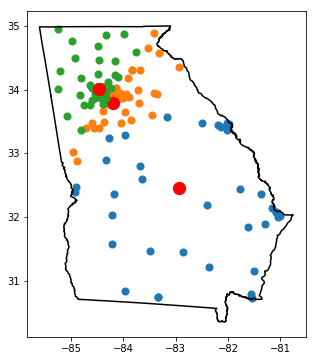

[38, 71, 83] 150.0


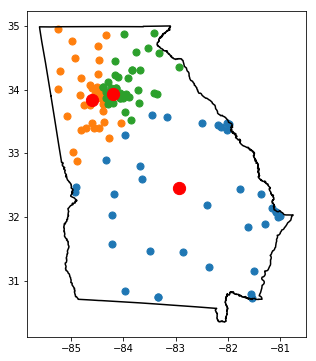

[7, 38, 83] 148.0


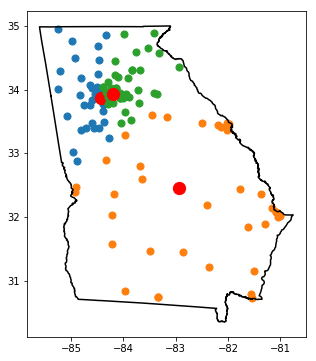

In [405]:
for solutions in best_nodes_list[-3:]:
    df_result = plot_best(solutions)

In [404]:
for node in best_nodes_list[-2]:
    val = df.iloc[node]
    print(val['City'], val['Zip'])

df['group'] = df['Unnamed: 0'].apply(lambda x: find_group(x, df_result, nodes))
df.head(5)

 Dublin 31021
 Mableton 30126-2353
 Norcross 30071-3338


,Unnamed: 0,lngCouncil,calCouncil,Address,City,State,Zip,Zip5,lat_lon,lat,lon,group
0,0,15996,St. John Paul II Council 15996,6301 Cedarcrest Road,Acworth,GA,30101,30101,"(34.0756, -84.6477)",34.0756,-84.6477,28
1,1,3607,Msgr. Daniel J. Bourke Council 3607,421 Edgewood Lane,Albany,GA,31707-3909,31707,"(31.5789, -84.2118)",31.5789,-84.2118,81
2,2,6532,St. Thomas Aquinas Council 6532,535 Rucker Road,Alpharetta,GA,30004-4048,30004,"(34.1124, -84.302)",34.1124,-84.3020,26
3,3,7113,Americus Council 7113,332 South Lee Street,Americus,GA,31709-3916,31709,"(32.0404, -84.2153)",32.0404,-84.2153,81
4,4,6514,Deacon William P. Lakin Council 6514,958 Epps Bridge Parkway,Athens,GA,30606,30606,"(33.9461, -83.41799999999998)",33.9461,-83.4180,26


## Check 38 as given:

In [409]:
def get_nodes(init_nodes):
    nodes = []
    for x in init_nodes:
        nodes.append(x)
    points_list = [x for x in range(max(df_dist['p2'])) if x not in init_nodes]
    for node in range(3-len(init_nodes)):
        choice = random.choice(points_list)
        nodes.append(choice)
        points_list.remove(choice)
    return nodes

In [ ]:
list_38 = []
best_result_38 = 1000


In [428]:
for x in range(100):
    nodes = get_nodes([38])
    nodes, cost = run_one_node(nodes)
    if cost<best_result_38:
        best_result_38 = cost
        best_nodes = nodes
        print(best_result_38, nodes)
        list_38.append(nodes)
#        plot_best(nodes)

In [429]:
list_38

[[38, 44, 25],
 [38, 6, 27],
 [38, 47, 32],
 [38, 90, 52],
 [38, 69, 39],
 [38, 8, 47],
 [38, 65, 74]]

## Changed distance metric to count only times over a certain length

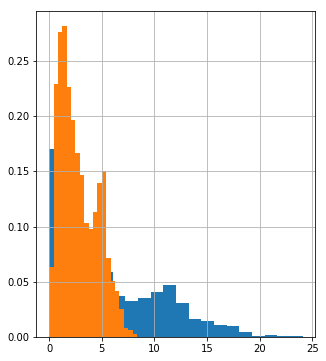

In [453]:

#df_dist['Floored'] = np.maximum(df_dist['Dist']-.75,0)
df_dist['Floored'] = df_dist['Dist']**1.5
df_dist['Floored'].hist(bins=20,density=True)
df_dist['Dist'].hist(bins=20, density=True)

In [436]:
def run_one_node_param(nodes = None, param='Dist'):
    
    if nodes == None:
        nodes = []

        points_list = [x for x in range(max(df_dist['p2']))]
        for node in range(3):
            choice = random.choice(points_list)
            nodes.append(choice)
            points_list.remove(choice)


    costs = []
    for x in range(max(df_dist['p2'])+1):
        if x in nodes:
            pass
        else:
            one_costs = []
            for y in nodes:
                if len(df_dist[(df_dist['p1']==x)&(df_dist['p2']==y)])==0:
                    one_costs.append(df_dist[(df_dist['p1']==y)&(df_dist['p2']==x)][param].values[0])
                else:
                    one_costs.append(df_dist[(df_dist['p1']==x)&(df_dist['p2']==y)][param].values[0])
            costs.append(one_costs)


    num_workers = len(costs)
    num_tasks = len(costs[0])


    # Create the mip solver with the SCIP backend.
    solver = pywraplp.Solver.CreateSolver('SCIP')


    # x[i, j] is an array of 0-1 variables, which will be 1
    # if worker i is assigned to task j.
    x = {}
    for i in range(num_workers):
        for j in range(num_tasks):
            x[i, j] = solver.IntVar(0, 1, '')


    # Each worker is assigned to at exactly 1 task.
    for i in range(num_workers):
        solver.Add(solver.Sum([x[i, j] for j in range(num_tasks)]) == 1)

    # Each task is assigned to exactly 2 workers. This is a function of total group size
    for j in range(num_tasks):
        solver.Add(solver.Sum([x[i, j] for i in range(num_workers)]) == num_workers/num_tasks)

    objective_terms = []
    for i in range(num_workers):
        for j in range(num_tasks):
            objective_terms.append(costs[i][j] * x[i, j])
    solver.Minimize(solver.Sum(objective_terms))
    status = solver.Solve()
    return nodes, solver.Objective().Value()


In [454]:
best_nodes_param = []
best_result = 1000

In [463]:
for x in range(1):
    nodes, cost = run_one_node_param(param='Floored')
    if cost<best_result:
        best_result = cost
        best_nodes = nodes
        print(best_result, nodes)
        best_nodes_param.append(nodes)
#        plot_best(nodes)

[110, 55, 74] 175.0


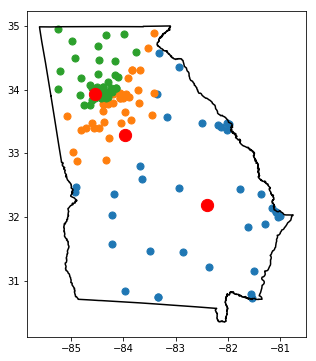

[77, 43, 38] 151.0


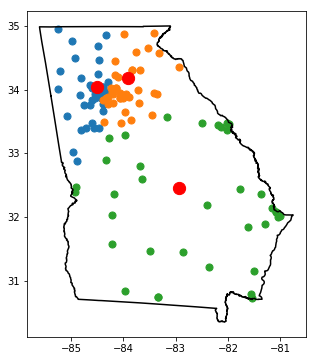

In [464]:
for solutions in best_nodes_param[1:]:
    df_result = plot_best(solutions)

In [448]:
best_nodes_param

[[97, 26, 37],
 [75, 78, 69],
 [61, 76, 68],
 [32, 38, 19],
 [57, 110, 91],
 [110, 35, 47]]